In [20]:
import cv2
import numpy as np
from keras.models import Model

def ScoreCam(model, img_array, layer_name, max_N=-1):

    cls = np.argmax(model.predict(img_array))
    act_map_array = Model(inputs=model.input, outputs=model.get_layer(layer_name).output).predict(img_array)

    # extract effective maps
    if max_N != -1:
        act_map_std_list = [np.std(act_map_array[0,:,:,k]) for k in range(act_map_array.shape[3])]
        unsorted_max_indices = np.argpartition(-np.array(act_map_std_list), max_N)[:max_N]

 

        max_N_indices = unsorted_max_indices[np.argsort(-np.array(act_map_std_list)[unsorted_max_indices])]
        act_map_array = act_map_array[:,:,:,max_N_indices]

    input_shape = model.layers[0].output_shape[1:]  # get input shape
    # 1. upsampled to original input size
    act_map_resized_list = [cv2.resize(act_map_array[0,:,:,k], input_shape[:2], interpolation=cv2.INTER_LINEAR) for k in range(act_map_array.shape[3])]
    # 2. normalize the raw activation value in each activation map into [0, 1]
    act_map_normalized_list = []
    for act_map_resized in act_map_resized_list:
        if np.max(act_map_resized) - np.min(act_map_resized) != 0:
            act_map_normalized = act_map_resized / (np.max(act_map_resized) - np.min(act_map_resized))
        else:
            act_map_normalized = act_map_resized
        act_map_normalized_list.append(act_map_normalized)
    # 3. project highlighted area in the activation map to original input space by multiplying the normalized activation map
    masked_input_list = []
    for act_map_normalized in act_map_normalized_list:
        masked_input = np.copy(img_array)
        for k in range(3):
            masked_input[0,:,:,k] *= act_map_normalized
        masked_input_list.append(masked_input)
    masked_input_array = np.concatenate(masked_input_list, axis=0)
    # 4. feed masked inputs into CNN model and softmax
    pred_from_masked_input_array = softmax(model.predict(masked_input_array))
    # 5. define weight as the score of target class
    weights = pred_from_masked_input_array[:,cls]
    # 6. get final class discriminative localization map as linear weighted combination of all activation maps
    cam = np.dot(act_map_array[0,:,:,:], weights)
    cam = np.maximum(0, cam)  # Passing through ReLU
    cam /= np.max(cam)  # scale 0 to 1.0

    return cam

def softmax(x):
    f = np.exp(x)/np.sum(np.exp(x), axis = 1, keepdims = True)
    return f

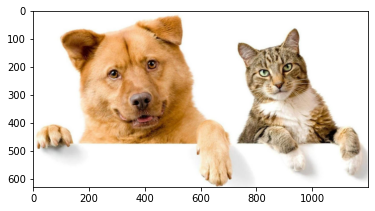

In [21]:
from keras.preprocessing.image import load_img
import matplotlib.pyplot as plt

orig_img = np.array(load_img('/home/rt2776/cnv_espresso/src_manuscript/dog_and_cat.jpg'),dtype=np.uint8)
plt.imshow(orig_img)
plt.show()

In [23]:
import gradcamutils

ModuleNotFoundError: No module named 'gradcamutils'

In [22]:
from keras.applications.vgg16 import VGG16
from gradcamutils import read_and_preprocess_img
import matplotlib.pyplot as plt

model = VGG16(include_top=True, weights='imagenet')
layer_name = 'block5_conv3'
img_array = read_and_preprocess_img('./home/rt2776/cnv_espresso/src_manuscript/dog_and_cat.jpg', size=(224,224))

score_cam = ScoreCam(model,img_array,layer_name)

plt.imshow(score_cam)
plt.show()

ModuleNotFoundError: No module named 'gradcamutils'

In [4]:
import tensorflow as tf

base_model = tf.keras.applications.MobileNet(
weights='imagenet',  # Load weights pre-trained model.
input_shape=(224, 224, 3),    #input_shape=(224, 224, 3),
include_top=False) 

In [5]:
base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

In [10]:
import keras

def recall_m(y_true, y_pred):
    true_positives = keras.backend.sum(keras.backend.round(keras.backend.clip(y_true * y_pred, 0, 1)))
    possible_positives = keras.backend.sum(keras.backend.round(keras.backend.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + keras.backend.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = keras.backend.sum(keras.backend.round(keras.backend.clip(y_true * y_pred, 0, 1)))
    predicted_positives = keras.backend.sum(keras.backend.round(keras.backend.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + keras.backend.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+keras.backend.epsilon()))
#ref: https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model



In [41]:
model_name='MobileNet_v1_modified'
learning_rate = 1e-4
nClasses=3
trainable=True

base_model = tf.keras.applications.MobileNet(
weights='imagenet',  # Load weights pre-trained model.
input_shape=(224, 224, 3),    #input_shape=(224, 224, 3),
include_top=False)  # Do not include the ImageNet classifier at the top.

print("Model name: %s, nClasses: %d, Learning rate:%f, Trainable: %s"%(model_name, nClasses, learning_rate, trainable))
base_model.trainable = trainable
inputs = keras.Input(shape=(224, 224, 3)) #keras.Input(shape=(224, 224, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = base_model(inputs, training=trainable)

# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)


# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(nClasses,activation='softmax')(x)

Model name: MobileNet_v1_modified, nClasses: 3, Learning rate:0.000100, Trainable: True


In [55]:
from keras.models import Sequential

In [70]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenet_1.00_224 (Model)   (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 3075      
Total params: 3,231,939
Trainable params: 3,210,051
Non-trainable params: 21,888
_________________________________________________________________


In [64]:
model_new = Sequential()
model_new.add(model.layers[0])

for layer_i in model.layers[1].layers:
    model_new.add(layer_i)
model_new.add(model.layers[2])
model_new.add(model.layers[3])
model_new.summary()

In [11]:





model = keras.Model(inputs, outputs)
#model.compile(loss='categorical_crossentropy', metrics=['accuracy', f1_m, precision_m, recall_m])
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy', metrics=['accuracy', f1_m, precision_m, recall_m])  
print("Number of base model layers:", len(base_model.layers))


Model name: MobileNet_v1_modified, nClasses: 3, Learning rate:0.000100, Trainable: True
Number of base model layers: 87


In [28]:
type(base_model(inputs, training=trainable))

tensorflow.python.framework.ops.Tensor

In [17]:
model.layers[1].summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32